# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_0
Gradient check passed!
Checking gradient for B_0
Gradient check passed!
Checking gradient for W_2
Gradient check passed!
Checking gradient for B_2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD())

loss_history, train_history, val_history = trainer.fit()

Loss: 2.216706, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.154270, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.100071, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286345, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.169583, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.064616, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.368611, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.111779, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.226791, Train accuracy: 0.207222, val accuracy: 0.215000
Loss: 2.069778, Train accuracy: 0.230333, val accuracy: 0.235000
Loss: 2.121233, Train accuracy: 0.257222, val accuracy: 0.258000
Loss: 2.110917, Train accuracy: 0.269000, val accuracy: 0.268000
Loss: 2.121928, Train accuracy: 0.282889, val accuracy: 0.287000
Loss: 2.001790, Train accuracy: 0.299556, val accuracy: 0.303000
Loss: 2.056521, Train accuracy: 0.323222, val accuracy: 0.323000
Loss: 1.858225, Train acc

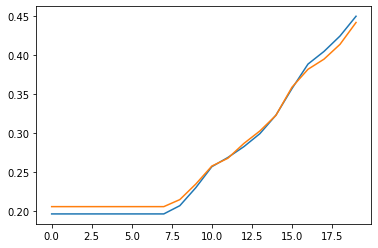

In [10]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.245684, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.372685, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.208299, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259444, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.181578, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.193982, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.085672, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321907, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.251000, Train accuracy: 0.200556, val accuracy: 0.208000
Loss: 2.196621, Train accuracy: 0.225333, val accuracy: 0.230000
Loss: 2.084484, Train accuracy: 0.241222, val accuracy: 0.242000
Loss: 2.095548, Train accuracy: 0.268222, val accuracy: 0.267000
Loss: 2.380465, Train accuracy: 0.277000, val accuracy: 0.272000
Loss: 1.767388, Train accuracy: 0.280444, val accuracy: 0.285000
Loss: 2.304647, Train accuracy: 0.299778, val accuracy: 0.307000
Loss: 1.941685, Train acc

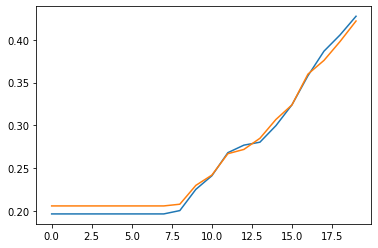

In [12]:
plt.plot(train_history)
plt.plot(val_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-3)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.153337, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.677622, Train accuracy: 0.344556, val accuracy: 0.355000
Loss: 1.395326, Train accuracy: 0.534444, val accuracy: 0.535000
Loss: 1.458161, Train accuracy: 0.601778, val accuracy: 0.594000
Loss: 1.387373, Train accuracy: 0.665000, val accuracy: 0.655000
Loss: 1.641804, Train accuracy: 0.672889, val accuracy: 0.657000
Loss: 1.006728, Train accuracy: 0.718000, val accuracy: 0.677000
Loss: 1.106447, Train accuracy: 0.706444, val accuracy: 0.660000
Loss: 1.365101, Train accuracy: 0.738222, val accuracy: 0.702000
Loss: 1.401117, Train accuracy: 0.745333, val accuracy: 0.692000
Loss: 0.846030, Train accuracy: 0.769000, val accuracy: 0.693000
Loss: 0.777381, Train accuracy: 0.773444, val accuracy: 0.712000
Loss: 0.852111, Train accuracy: 0.794333, val accuracy: 0.722000
Loss: 0.662009, Train accuracy: 0.773333, val accuracy: 0.711000
Loss: 1.305905, Train accuracy: 0.803000, val accuracy: 0.728000
Loss: 1.131954, Train acc

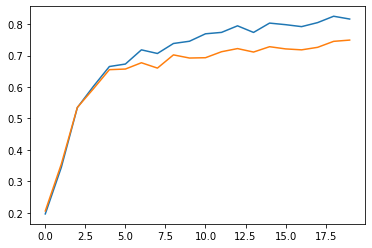

In [14]:
plt.plot(train_history)
plt.plot(val_history)

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [15]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.351618, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.318467, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.291136, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341864, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302463, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.319034, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.235521, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.170412, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.144598, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.000302, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.842682, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.238035, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.616099, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.203432, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.902569, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.637197, Train acc

Loss: 1.138238, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.135899, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.166023, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.297579, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.133557, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.212286, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.282922, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.026195, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.237881, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.280440, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 1.126200, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.263944, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.136968, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.371337, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.229599, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.242691, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [16]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 1000, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=2)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.272414, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.406906, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.983446, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.836979, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 0.712707, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.394103, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 2.276459, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.013791, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.333519, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 0.319715, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 0.737455, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 0.194038, Train accuracy: 0.800000, val accuracy: 0.000000
Loss: 2.121524, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.101273, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 0.100393, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.184663, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [17]:
best_learning_rate          = None
best_reg_strength           = None
best_learning_rate_decay    = None
best_hidden_layer_size      = None
best_num_epochs             = None
best_batch_size             = None

default_learning_rate       = 1e-3
default_reg_strength        = 1e-3
default_learning_rate_decay = 1
default_hidden_layer_size   = 16
default_batch_size          = 64
default_num_epochs          = 50

dataset = Dataset(train_X, train_y, val_X, val_y)

In [18]:
best_val_accuracy   = None

learning_rates      = [1e-1, 1e-2, 1e-3, 1e-4]

reg_strength        = default_reg_strength
learning_rate_decay = default_learning_rate_decay
batch_size          = default_batch_size
num_epochs          = default_num_epochs
hidden_layer_size   = default_hidden_layer_size

for learning_rate in learning_rates:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=hidden_layer_size, 
                        reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), num_epochs, batch_size, learning_rate, learning_rate_decay)
    
    loss_history, train_history, val_history = trainer.fit(out=False)
    
    if best_val_accuracy is None or val_history[-1] > best_val_accuracy:
        best_learning_rate = learning_rate
        best_val_accuracy = val_history[-1]
        
    print('Learning rate = %f' % learning_rate, flush=True)
    print('Accuracy = %f' % val_history[-1], flush=True)
    
print('\n===============Best_results===============\n', flush=True)
print('Learning rate = %f' % best_learning_rate, flush=True)
print('Accuracy = %f' % best_val_accuracy, flush=True)

100%|██████████| 50/50 [00:24<00:00,  2.01it/s]

Learning rate = 0.100000
Accuracy = 0.603000



100%|██████████| 50/50 [00:26<00:00,  1.92it/s]

Learning rate = 0.010000
Accuracy = 0.689000



100%|██████████| 50/50 [00:27<00:00,  1.85it/s]

Learning rate = 0.001000
Accuracy = 0.275000



100%|██████████| 50/50 [00:22<00:00,  2.27it/s]

Learning rate = 0.000100
Accuracy = 0.206000

===============Best_results===============

Learning rate = 0.010000
Accuracy = 0.689000


In [19]:
best_val_accuracy   = None

learning_rate       = best_learning_rate

reg_strengths       = [1, 1e-1, 1e-2, 1e-3, 1e-4]

learning_rate_decay = default_learning_rate_decay
batch_size          = default_batch_size
num_epochs          = default_num_epochs
hidden_layer_size   = default_hidden_layer_size

for reg_strength in reg_strengths:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=hidden_layer_size, 
                        reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), num_epochs, batch_size, learning_rate, learning_rate_decay)
    
    loss_history, train_history, val_history = trainer.fit(out=False)
    
    if best_val_accuracy is None or val_history[-1] > best_val_accuracy:
        best_reg_strength = reg_strength
        best_val_accuracy = val_history[-1]
        
    print('Regularization strength = %f' % reg_strength, flush=True)
    print('Accuracy = %f' % val_history[-1], flush=True)
    
print('\n===============Best_results===============\n', flush=True)
print('Regularization strength = %f' % best_reg_strength, flush=True)
print('Accuracy = %f' % best_val_accuracy, flush=True) 

100%|██████████| 50/50 [00:20<00:00,  2.49it/s]

Regularization strength = 1.000000
Accuracy = 0.206000



100%|██████████| 50/50 [00:22<00:00,  2.26it/s]

Regularization strength = 0.100000
Accuracy = 0.206000



100%|██████████| 50/50 [00:19<00:00,  2.57it/s]

Regularization strength = 0.010000
Accuracy = 0.623000



100%|██████████| 50/50 [00:19<00:00,  2.56it/s]

Regularization strength = 0.001000
Accuracy = 0.685000



100%|██████████| 50/50 [00:19<00:00,  2.55it/s]

Regularization strength = 0.000100
Accuracy = 0.656000

===============Best_results===============

Regularization strength = 0.001000
Accuracy = 0.685000


In [22]:
best_val_accuracy    = None

learning_rate        = best_learning_rate
reg_strength         = best_reg_strength

learning_rate_decays = [0.8, 0.85, 0.9, 0.95, 0.99]

batch_size           = default_batch_size
num_epochs           = default_num_epochs
hidden_layer_size    = default_hidden_layer_size

for learning_rate_decay in learning_rate_decays:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=hidden_layer_size, 
                        reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), num_epochs, batch_size, learning_rate, learning_rate_decay)
    
    loss_history, train_history, val_history = trainer.fit(out=False)
    
    if best_val_accuracy is None or val_history[-1] > best_val_accuracy:
        best_learning_rate_decay = learning_rate_decay
        best_val_accuracy = val_history[-1]
        
    print('Learning rate decay = %f' % learning_rate_decay, flush=True)
    print('Accuracy = %f' % val_history[-1], flush=True)
    
print('\n===============Best_results===============\n', flush=True)
print('Learning rate decay = %f' % best_learning_rate_decay, flush=True)
print('Accuracy = %f' % best_val_accuracy, flush=True) 

100%|██████████| 50/50 [00:21<00:00,  2.30it/s]

Learning rate decay = 0.800000
Accuracy = 0.279000



100%|██████████| 50/50 [00:19<00:00,  2.54it/s]

Learning rate decay = 0.850000
Accuracy = 0.357000



100%|██████████| 50/50 [00:19<00:00,  2.53it/s]

Learning rate decay = 0.900000
Accuracy = 0.536000



100%|██████████| 50/50 [00:19<00:00,  2.56it/s]

Learning rate decay = 0.950000
Accuracy = 0.667000



100%|██████████| 50/50 [00:19<00:00,  2.57it/s]

Learning rate decay = 0.990000
Accuracy = 0.681000

===============Best_results===============

Learning rate decay = 0.990000
Accuracy = 0.681000


In [23]:
best_val_accuracy   = None

learning_rate       = best_learning_rate
reg_strength        = best_reg_strength
learning_rate_decay = best_learning_rate_decay

batch_sizes         = [2, 4, 8, 16, 32, 64, 128, 256, 512]

num_epochs          = default_num_epochs
hidden_layer_size   = default_hidden_layer_size

for batch_size in batch_sizes:
    model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                        hidden_layer_size=hidden_layer_size, 
                        reg=reg_strength)
    trainer = Trainer(model, dataset, MomentumSGD(), num_epochs, batch_size, learning_rate, learning_rate_decay)
    
    loss_history, train_history, val_history = trainer.fit(out=False)
    
    if best_val_accuracy is None or val_history[-1] > best_val_accuracy:
        best_batch_size = batch_size
        best_val_accuracy = val_history[-1]
        
    print('Batch size = %d' % batch_size, flush=True)
    print('Accuracy = %f' % val_history[-1], flush=True)
    
print('\n===============Best_results===============\n', flush=True)
print('Batch size = %d' % best_batch_size, flush=True)
print('Accuracy = %f' % best_val_accuracy, flush=True) 

100%|██████████| 50/50 [01:49<00:00,  2.20s/it]

Batch size = 2
Accuracy = 0.469000



100%|██████████| 50/50 [00:58<00:00,  1.17s/it]

Batch size = 4
Accuracy = 0.575000



100%|██████████| 50/50 [01:03<00:00,  1.27s/it]

Batch size = 8
Accuracy = 0.683000



100%|██████████| 50/50 [00:38<00:00,  1.28it/s]

Batch size = 16
Accuracy = 0.693000



100%|██████████| 50/50 [00:25<00:00,  1.96it/s]

Batch size = 32
Accuracy = 0.693000



100%|██████████| 50/50 [00:21<00:00,  2.36it/s]

Batch size = 64
Accuracy = 0.682000



100%|██████████| 50/50 [00:18<00:00,  2.77it/s]

Batch size = 128
Accuracy = 0.595000



100%|██████████| 50/50 [00:19<00:00,  2.54it/s]

Batch size = 256
Accuracy = 0.468000



100%|██████████| 50/50 [00:17<00:00,  2.81it/s]

Batch size = 512
Accuracy = 0.279000

===============Best_results===============

Batch size = 16
Accuracy = 0.693000


In [24]:
print('best_learning_rate:', best_learning_rate)
print('best_reg_strength:', best_reg_strength)
print('best_learning_rate_decay:', best_learning_rate_decay)
print('best_batch_size:', best_batch_size)

best_learning_rate: 0.01
best_reg_strength: 0.001
best_learning_rate_decay: 0.99
best_batch_size: 16


In [25]:
best_batch_size        = 32
best_hidden_layer_size = 256
best_num_epochs        = 200

best_classifier = TwoLayerNet(n_input=train_X.shape[1], n_output=10, 
                                hidden_layer_size=best_hidden_layer_size, 
                                reg=best_reg_strength)

trainer = Trainer(best_classifier, dataset, MomentumSGD(), best_num_epochs, 
                  batch_size=best_batch_size, learning_rate=best_learning_rate, 
                  learning_rate_decay=best_learning_rate_decay)

loss_history, train_history, val_history = trainer.fit(out=False)
best_val_accuracy = val_history[-1]

100%|██████████| 200/200 [19:24<00:00,  5.82s/it]


In [26]:
print('best validation accuracy achieved: %f' % best_val_accuracy)

best validation accuracy achieved: 0.798000


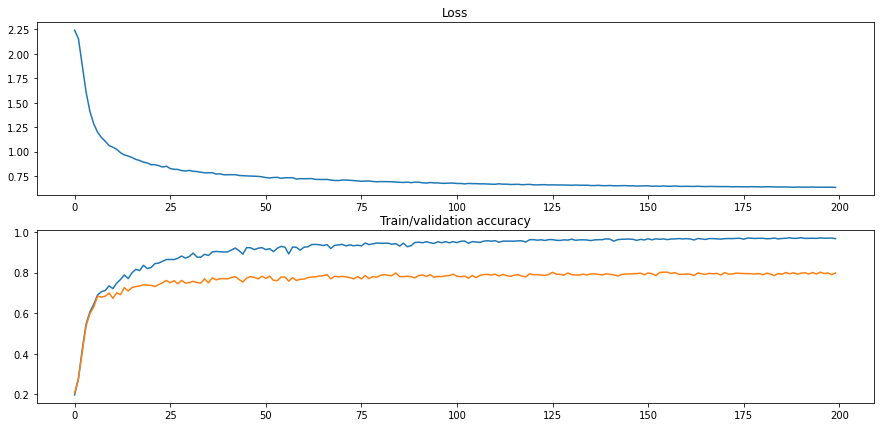

In [27]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [28]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.772000


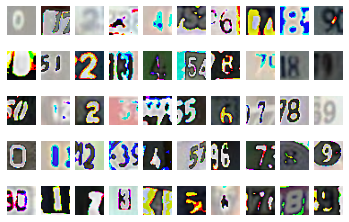

Predicted:
[[3 7 2 3 4 5 6 7 5 9]
 [2 4 2 3 1 5 0 7 8 1]
 [0 1 2 3 4 5 6 7 8 9]
 [3 1 2 3 4 3 6 7 3 2]
 [0 1 2 8 4 5 6 7 9 9]]


In [30]:
samples_per_class = 5
digits_count = 10

preds = []

plot_index = 0
for index in range(samples_per_class):
    for digit in range(digits_count):
        digit_indices = test_y == digit
        test_X_cur = test_X[digit_indices]
        test_y_cur = test_y[digit_indices]

        test_indices = np.arange(test_y_cur.size)
        random_indices = np.random.choice(test_indices)

        image = test_X_cur[random_indices]
        pred = best_classifier.predict(image)
        preds.append(pred)
        
        image = image.reshape(32, 32, 3) * 255.0
    
        plt.subplot(samples_per_class, digits_count, index * digits_count + digit + 1)
        plt.imshow(image.astype(np.uint8))
        plt.axis('off')
        plot_index += 1
        
plt.show()

preds = np.array(preds).reshape(samples_per_class, digits_count)
print('Predicted:\n' + str(preds))